In [55]:
import sys
import os
import time
import math
from functools import partial
import numpy as np
from astropy.io import fits
import scipy.io as sio

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


import large_scale_UQ as luq
from convex_reg import utils as utils_cvx_reg

from tqdm import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from large_scale_UQ.utils import to_numpy, to_tensor

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


True
1
0
NVIDIA A100-PCIE-40GB


In [56]:
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}


In [57]:
# repo_dir = '/Users/tl/Documents/research/repos/proj-convex-UQ/large-scale-UQ'
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
save_dir = repo_dir + '/notebooks/SAPG/output/'
savefig_dir = repo_dir + '/notebooks/SAPG/figs/'

# optimization settings
wavs =  ["db8"]# ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 4 # 3                                               # Wavelet levels to consider [1-6]
reg_param = 50. # 2.e-3
img_name = 'M31'

# Saving names
save_name = '{:s}_256_wavelet_SAPG-{:s}_{:d}_reg_{:.1f}'.format(
    img_name, wavs[0], levels, reg_param
)


# Load img
img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img
 
 
# Load op from X Cai
op_mask = sio.loadmat(repo_dir + '/data/operators_masks/fourier_mask.mat')['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

# Define my torch types
myType = torch.float32
myComplexType = torch.complex64

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape)
dim = img.shape[0]

# A mock radio imaging forward model with half of the Fourier coefficients masked
# Use X. Cai's Fourier mask
phi = luq.operators.MaskedFourier_torch(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)

# Define X Cai noise level
sigma = 0.0024
sigma2 = sigma**2

sigma_GT = np.copy(sigma)
sigma2_GT = np.copy(sigma2)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))



In [58]:
sigma2

5.759999999999999e-06

In [59]:

# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# g.beta = 1.0 / sigma ** 2

# Define real prox
f = luq.operators.RealProx_torch()


# Define the wavelet dict
# Define the l1 norm with dict psi
# gamma = torch.max(torch.abs(psi.dir_op(y_torch))) * reg_param
# psi = luq.operators.DictionaryWv_torch(wavs, levels)

# h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
# gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(x_init))) # * reg_param
# h.gamma = gamma
# h.beta = 1.0


In [60]:

torch.set_grad_enabled(False)
torch.set_num_threads(4)

sigma_training = 5
t_model = 5
dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(dir_name+exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

L_CRR = model.L.detach().cpu().squeeze().numpy()
print(f"Lipschitz bound {L_CRR:.3f}")


# %%
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")



--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770
Lipschitz bound 0.770


In [61]:

# Define sigma bounds
min_sigma2 = torch.tensor(1e-12, device=device, dtype=myType)
max_sigma2 = torch.tensor(1e3, device=device, dtype=myType)
sigma2_init = torch.tensor(1e-6, device=device, dtype=myType)



In [62]:
# Negative log-likelihood -logp(t|x,sigma^2)
f = lambda _x, sigma2: g.fun(_x, sigma2=sigma2)

# --- Gradient w.r.t. sigma^2
dimx = x.size
alpha_homogenious = 1
# df_wrt_sigma2 = lambda _x, sigma2: torch.real(g.grad_sigma2(_x, sigma2=sigma2)) - dimx / (alpha_homogenious * sigma2)
df_wrt_sigma2 = lambda _x, sigma2: torch.real(g.grad_sigma2(_x, sigma2=sigma2))
# Note: The second part corresponds to the normalisation constant Z of the posterior

# --- Gradient w.r.t. x
df_wrt_x = lambda _x, sigma2: torch.real(g.grad(_x, sigma2=sigma2))


In [63]:
# Define prior
mu = 20.
# fun_prior = lambda _x : h._fun_coeffs(h.dir_op(torch.clone(_x)))
fun_prior = lambda _x : model.cost(mu * _x) / mu

# sub_op = lambda _x1, _x2 : _x1 - _x2
# # proximity operator
# prox_prior_cai = lambda _x, lmbd : torch.clone(_x) + h.adj_op(h._op_to_two_coeffs(
#     h.prox(h.dir_op(torch.clone(_x)), lmbd),
#     h.dir_op(torch.clone(_x)), sub_op
# ))
# prox_prior = lambda _x, lmbd : h.adj_op(h.prox(h.dir_op(torch.clone(_x)), lmbd))

# gradient of the prior
# gradg = lambda x, lam, lambda_prox: torch.real(x - prox_prior_cai(x,lam)) / lambda_prox 

gradg = lambda _x, lmbd : lmbd * model(mu * _x)


In [64]:
# Log of posterior distribution
logPi = lambda _x, sigma2, theta: (- f(_x, sigma2) - theta * fun_prior(_x))


In [67]:
# --- Initialization of parameter theta
th_init = 1e3 # 0.01

# --- Admisible set for \theta (min and max values).
min_th = 1. # 0.001
max_th = 1e6 # 1

# --- define stepsize delta 
d_exp = 0.8
delta = lambda _i: (_i**(-d_exp)) / dimx 

# --- constant to tune the stepsize of each parameter
c_theta = 1e2 # 1e1
c_sigma2 = 5e0 # 1e5


In [65]:

## Lipschitz Constants

# --- Maximum eigenvalue of operator A. Norm of blurring operator.
g._compute_lip_constant()
AAt_norm =  g.beta * (g.sigma**2) 

# Lipshcitz constant of f.
Lp_fun = lambda sigma2: AAt_norm**2 / sigma2  
# L_f =  min(Lp_fun(min_sigma2), Lp_fun(max_sigma2))
# L_f= Lp_fun(sigma2_init)
L_f= Lp_fun(sigma2_GT)

# --- regularization parameter of proximity operator (\lambda).
# lambdaMax = 2
# lambda_prox = min((1/L_f), lambdaMax)   
# --- end

# --- Lipshcitz constant of g.
# L_g =  1/lambda_prox 
L_g = L_CRR * mu * th_init

# --- Lipshcitz constant of g + f
L =  L_f + L_g
# --- end

# --- Stepsize of MCMC algorithm.
gamma = 0.98/L
# --- end


In [66]:
print('L: ', L)
print('gamma: ', gamma)
# print('lambda_prox: ', lambda_prox)



L:  173611.7979321115
gamma:  5.64477766875737e-06


In [68]:
# --- Warmup period for the MCMC sampling
warmupSteps = 1000

# --- total number of iterations for the optimization algorithm on theta
total_iter = np.int64(2e4)

# --- burn-in period for the optimization algorithm on theta
burnIn = int(total_iter * 0.8)

In [69]:
# --- Initialization of the warm-up chain
# X_wu = y.to(device).detach().clone()
x_init = torch.abs(phi.adj_op(torch_y))
X_wu = torch.clone(x_init)

#Run MYULA sampler with fix theta and fix sigma^2 to warm up the markov chain

fix_sigma2 = torch.tensor(sigma2_GT, device=device, dtype=myType) #sigma2_init
fix_theta = th_init

print('Running Warm up     \n')

for k in tqdm(range(1,warmupSteps)):
    # --- Gradients
    gradf_X_wu = df_wrt_x(X_wu, fix_sigma2)
    gradg_X_wu = gradg(X_wu, fix_theta)
    # --- end (gradients)
    
    # --- MYULA warm-up
    X_wu =  X_wu - gamma*gradg_X_wu - gamma*gradf_X_wu + math.sqrt(2*gamma)*torch.randn_like(X_wu)
    # --- end (warm-up)


Running Warm up     



100%|██████████| 999/999 [00:01<00:00, 815.84it/s]


In [70]:
np_sigma2_GT = np.copy(sigma2_GT)
sigma2_GT = torch.tensor(sigma2_GT, device=device, dtype=myType)

In [71]:
# Keeping track of the reg. parameter's trace
theta_trace = torch.zeros(total_iter)
theta_trace[0] = th_init

sigma2_trace= torch.zeros(total_iter)
sigma2_trace[0]= sigma2_init

# We work on a logarithmic scale, so we define an axiliary variable 
#eta such that theta=exp{eta}. 

eta_init = math.log(th_init)
min_eta = math.log(min_th)
max_eta = math.log(max_th)

eta_trace = torch.zeros(total_iter)
eta_trace[0] = eta_init

# Repeat the log scale on the sigma2
mu_init = math.log(sigma2_init)
min_mu = math.log(min_sigma2)
max_mu = math.log(max_sigma2)

mu_trace = torch.zeros(total_iter)
mu_trace[0] = mu_init

# Stop criteria (relative change tolerance) for the proximal gradient algorithm

stopTol=1e-5


In [72]:
print('\nRunning SAPG algorithm     \n')
# We want to keep track of two traces: the log-likelihood and the TV function to monitor the behaviour of the algorithm.

logPiTraceX = []      # to monitor convergence
g_trace = []          # to monitor how the regularisation function evolves

mean_theta =[]
mean_sigma2 = []
Grad_sigma2 = []

X = X_wu.clone()       # start MYULA markov chain from last sample after warmup

update_iter = 100

# for k in tqdm(range(1,total_iter)): 
for k in range(1,total_iter): 

    ################################################################################
    # MCMC SAMPLER
    ################################################################################

    # Number of samples

    m = 3

    # If we run the MCMC sampler for m times to get m samples X_m, therefore we need to average 
    # gradients w.r.t. \theta and \sigma^2 before the update
    g_mcmc_trace = torch.zeros(m, device=device) # .to(device) 
    grad_sigma2_trace = torch.zeros(m, device=device) # .to(device) 
    
    #Sample from posterior with MYULA:
    
    for ii in range(m):

        # Calculate the gradient related to g for the current theta
        gradgX = gradg(X, theta_trace[k-1])    
        
        # --- Calculate the gradient related to f for the current theta
        gradfX = df_wrt_x(X,sigma2_trace[k-1])
        # gradfX = df_wrt_x(X,sigma2_GT)
        # --- end
        
        # --- MYULA update
        X =  X - gamma*gradgX - gamma*gradfX + math.sqrt(2*gamma)*torch.randn_like(X)
        #X = torch.clamp(X,0,255)
        # --- end
        
        # --- Gardients w.r.t parameters
        g_mcmc_trace[ii] = fun_prior(X)
        grad_sigma2_trace[ii] = df_wrt_sigma2(X, sigma2_trace[k-1])
        # --- end
        
    # --- Save current state to monitor convergence
    logPiTraceX.append(logPi(X, sigma2_trace[k-1],theta_trace[k-1]).cpu().numpy())
    # logPiTraceX.append(logPi(X, sigma2_GT, theta_trace[k-1]).cpu().numpy())
    g_trace.append(g_mcmc_trace[-1].cpu().numpy())
    # --- end (monitoring)
    
    # ################################################################################
    #  PROJECTED GRADIENT ALGORITHM
    # ################################################################################

    # Update eta and theta. It should be underlined that we work on the logarithmic
    # scale for numerical stability

    # --- update \eta and \theta
    alpha_homogenious_CRR = 2
    etak = eta_trace[k-1] + c_theta * delta(k)  * (dimx / (alpha_homogenious_CRR * theta_trace[k-1]) - torch.mean(g_mcmc_trace)) * torch.exp(eta_trace[k-1]) 

    # project \eta onto the admissible set of value
    eta_trace[k] = min(max(etak,min_eta),max_eta)
    
    # Save the value of theta
    theta_trace[k] = torch.exp(eta_trace[k])
    # --- end (update)
    
    # --- Update sigma^2
    # sigma2_k = sigma2_trace[k-1] + c_sigma2 * delta(k) * torch.mean(grad_sigma2_trace)
    alpha_homogenious_sigma = -1.
    mu_k = mu_trace[k-1] + c_sigma2 * delta(k) * (
        dimx / (alpha_homogenious_sigma * sigma2_trace[k-1]) - torch.mean(grad_sigma2_trace)
    ) * torch.exp(mu_trace[k-1]) 

    mu_trace[k] = min(max(mu_k, min_mu), max_mu)
    sigma2_trace[k] = torch.exp(mu_trace[k])
    # sigma2_trace[k] = sigma2_GT
    # --- end (update)
    
    # -- 
    Grad_sigma2.append(df_wrt_sigma2(X, sigma2_trace[k-1]).cpu().numpy())
    if k % update_iter == 0:
        print(f"iter = {k} \t Theta = {theta_trace[k]} \t sigma2 = {sigma2_trace[k]}\n")
        # print(f"iter = {k} \t Theta = {theta_trace[k]}\n")
   
    # --- Check stop criteria. If relative error is smaller than op.stopTol stop
    
    if k>burnIn+1:
        mean_theta.append(torch.mean(theta_trace[burnIn:(k+1)]).cpu().numpy())
        mean_sigma2.append(torch.mean(sigma2_trace[burnIn:(k+1)]).cpu().numpy())
        
        relErrTh1 = torch.abs(torch.mean(theta_trace[burnIn:(k+1)]) - torch.mean(theta_trace[burnIn:k])) / torch.mean(theta_trace[burnIn:k])
        
        relErrSi1 = torch.abs(torch.mean(sigma2_trace[burnIn:(k+1)]) - torch.mean(sigma2_trace[burnIn:k])) / torch.mean(sigma2_trace[burnIn:k])

        if (relErrTh1<stopTol) and (relErrSi1<stopTol) and 1 == 2 :
        # if (relErrTh1<stopTol) and 1 == 2 :    
            print("Toleration reached!")
            break
     # --- end (stop criteria)       

# --- Collecting data
last_samp = k

logPiTraceX = logPiTraceX[:last_samp+1]
gXTrace = g_trace[:last_samp+1]

theta_EB = torch.exp(torch.mean(eta_trace[burnIn:last_samp+1]))
last_theta = theta_trace[last_samp]
thetas = theta_trace[:last_samp+1]

sigma2_EB = torch.exp(torch.mean(mu_trace[burnIn:last_samp+1]))
last_sigma2 = sigma2_trace[last_samp]
sigmas2 = sigma2_trace[:last_samp+1]




Running SAPG algorithm     

-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------
iter = 100 	 Theta = 3511.130859375 	 sigma2 = 2.0857196432189085e-06

iter = 200 	 Theta = 2470.528076171875 	 sigma2 = 3.3479432204330806e-06

iter = 300 	 Theta = 2020.38134765625 	 sigma2 = 3.0864382551953895e-06

iter = 400 	 Theta = 1748.13330078125 	 sigma2 = 3.780631232075393e-06

iter = 500 	 Theta = 1566.15380859375 	 sigma2 = 2.8981385185034014e-06

iter = 600 	 Theta = 1421.6141357421875 	 sigma2 = 2.665931333467597e-06

iter = 700 	 Theta = 1320.6536865234375 	 sigma2 = 3.3350147532473784e-06

iter = 800 	 Theta = 1237.5250244140625 	 sigma2 = 2.8906633815495297e-06

iter = 900 	 Theta = 1168.475341796875 	 sigma2 = 2.6867635369853815e-06

iter = 1000 	 Theta = 1109.8599853515625 	 sigma2 = 3.0951396183809265e-06

iter = 1100 	 Theta = 1063.0372314453

In [73]:
# Estimated theta:  tensor(5.2098)
# Last theta:  tensor(5.0593)


In [74]:
sigma2_GT

tensor(5.7600e-06, device='cuda:0')

In [75]:
print("Estimated theta: ", theta_EB)
print("Last theta: ", last_theta)
# print("Estimated value of sigma2 ",sigma2_EB, sigma**2)

# m=1
# Estimated theta:  tensor(6.7554)
# Last theta:  tensor(6.5733)
# m=10
# Estimated theta:  tensor(5.0369)
# Last theta:  tensor(4.9299)

Estimated theta:  tensor(187.6889)
Last theta:  tensor(177.7991)


In [76]:
print("Estimated sigma2_EB: ", sigma2_EB)
print("Last sigma2: ", last_sigma2)
print('GT sigma2: ', sigma2_GT.item())

print('Estimated sigma_EB: ', np.sqrt(sigma2_EB.item()))
print('GT sigma: ', np.sqrt(sigma2_GT.item()))

# print("Estimated value of sigma2 ",sigma2_EB, sigma**2)

Estimated sigma2_EB:  tensor(2.8248e-06)
Last sigma2:  tensor(2.7551e-06)
GT sigma2:  5.760000021837186e-06
Estimated sigma_EB:  0.001680723821280426
GT sigma:  0.0024000000045494136


In [77]:
# Estimated sigma2_EB:  tensor(2.4661e-07)
# Last sigma2:  tensor(2.2290e-07)
# GT sigma2:  5.759999999999999e-06
# Estimated sigma_EB:  0.0004966016915510602
# GT sigma:  0.0024

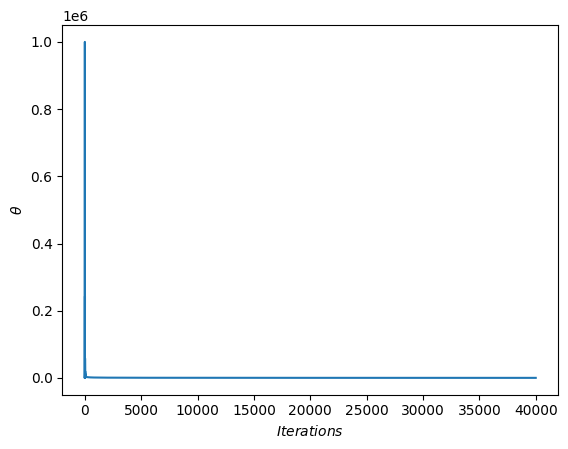

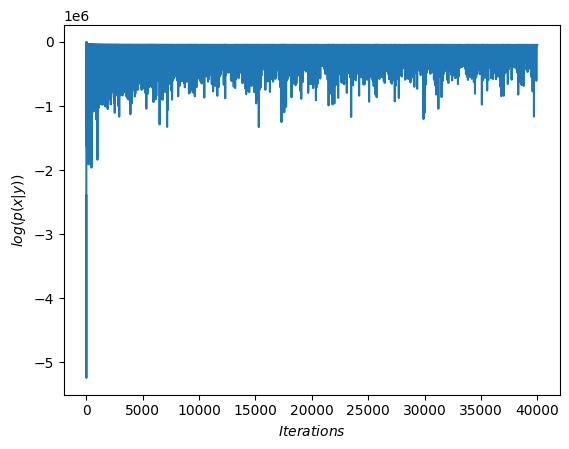

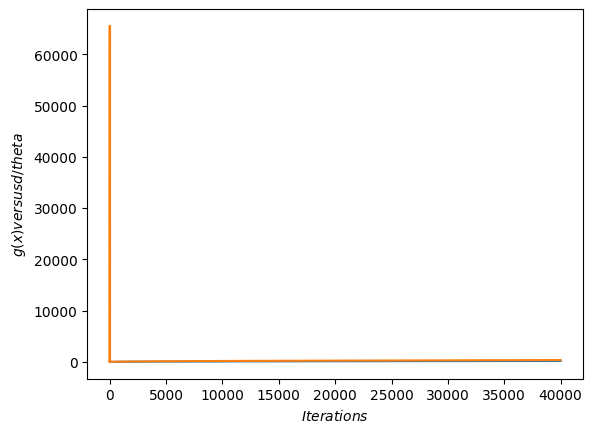

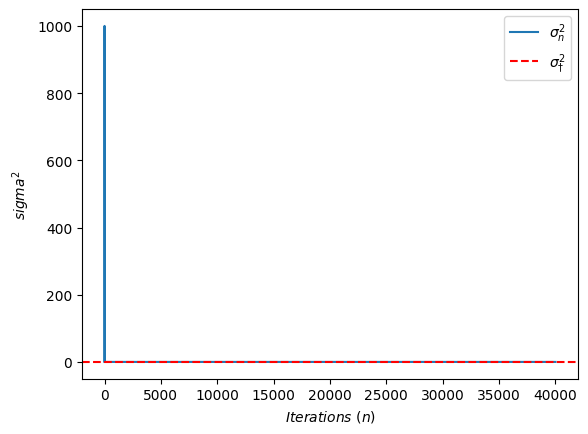

In [78]:
# Plot the results

plot1 = plt.figure()
plt.plot(thetas[:].cpu().numpy(),linestyle="-")
plt.xlabel("$Iterations$")
plt.ylabel("$θ$")

plot1 = plt.figure()
plt.plot( logPiTraceX,linestyle="-")
plt.xlabel("$Iterations$")
plt.ylabel("$log(p(x|y))$")

plot1 = plt.subplots()
plt.plot( gXTrace[:],linestyle="-")
plt.plot( 256*256/thetas[:].cpu().numpy(),linestyle="-")
plt.xlabel("$Iterations$")
plt.ylabel("$g(x) versus d/theta$")

fig, ax = plt.subplots()
ax.plot(sigmas2.cpu().numpy(),linestyle="-",label="$σ_{n}^{2}$")
plt.axhline(y=sigma**2, color='r', linestyle='--',label="$σ_{\dagger}^{2}$")
#plt.ylim(min_sigma2, max_sigma2)
ax.set_xlabel("$Iterations\,\,(n)$")
ax.set_ylabel("$sigma^{2}$")
ax.legend()


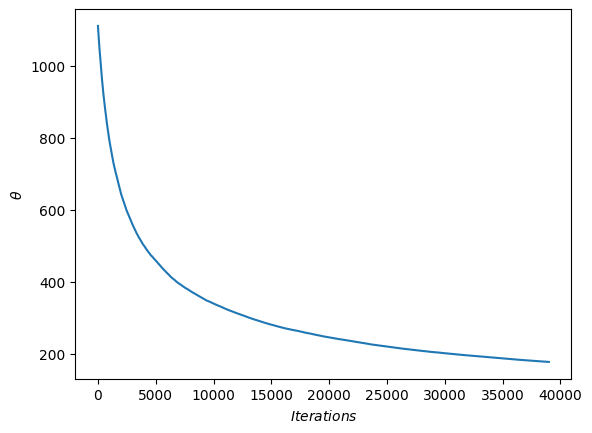

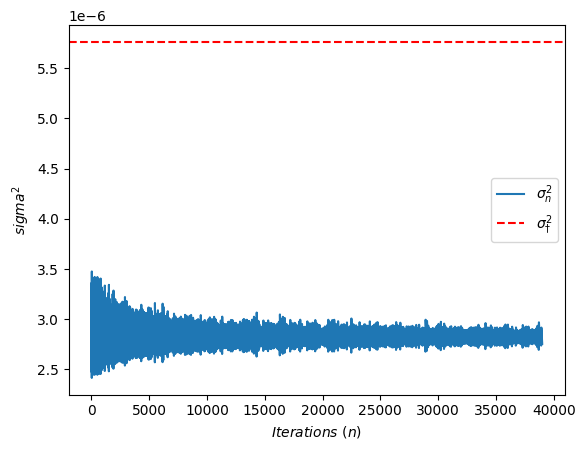

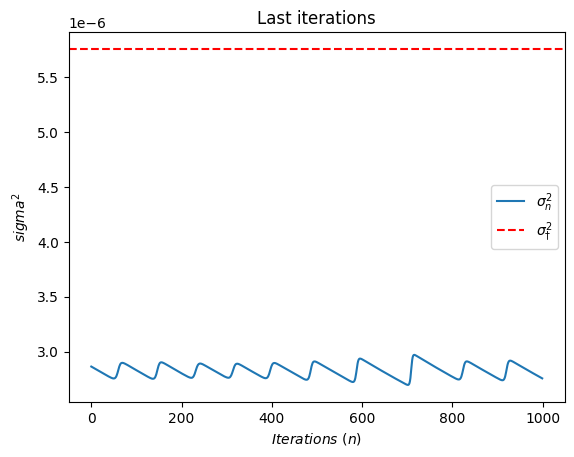

In [79]:
start_it = 1000

plot1 = plt.figure()
plt.plot(thetas[start_it:].cpu().numpy(),linestyle="-")
plt.xlabel("$Iterations$")
plt.ylabel("$θ$")


fig, ax = plt.subplots()
ax.plot(sigmas2[start_it:].cpu().numpy(),linestyle="-",label="$σ_{n}^{2}$")
plt.axhline(y=sigma**2, color='r', linestyle='--',label="$σ_{\dagger}^{2}$")
#plt.ylim(min_sigma2, max_sigma2)
ax.set_xlabel("$Iterations\,\,(n)$")
ax.set_ylabel("$sigma^{2}$")
ax.legend()


fig, ax = plt.subplots()
plt.title('Last iterations')
ax.plot(sigmas2[len(sigmas2)-start_it:].cpu().numpy(),linestyle="-",label="$σ_{n}^{2}$")
plt.axhline(y=sigma**2, color='r', linestyle='--',label="$σ_{\dagger}^{2}$")
#plt.ylim(min_sigma2, max_sigma2)
ax.set_xlabel("$Iterations\,\,(n)$")
ax.set_ylabel("$sigma^{2}$")
ax.legend()

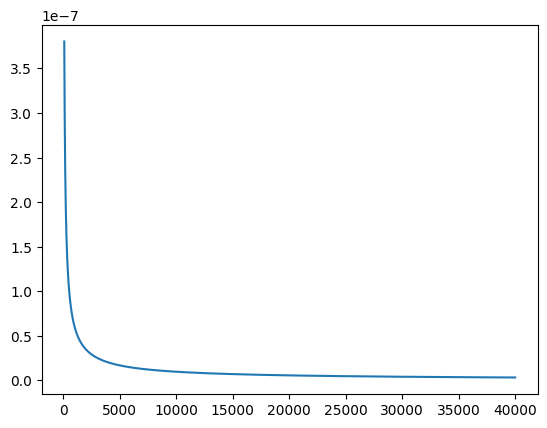

In [80]:

iters = np.linspace(1, total_iter, total_iter)

plt.figure()
plt.plot(iters[100:], delta(iters[100:]))
plt.show()

